In [2]:
import cv2
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn

In [3]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Creating CNN model
class TrafficSignalClassificationModelV1(nn.Module):
    """
    Model architecture is inspired from TineyVGG model from
    CNN explainer website
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int,
                 dropout_rate: float = 0.5):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,  # The kernel size 3 is equivalent to (3, 3) touple, same as 3x3 matrix
                      stride=1,
                      padding=1),      # kernel_size, stride, padding are the Conv2d hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout(p=dropout_rate)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_rate)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.conv_block_3(x)
        # print(f"Output shape of conv_block_3: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of clsssifier: {x.shape}")
        return x

In [5]:
# Load saved model
import os
import torch
from google.colab import drive

drive.mount('/content/drive')

MODEL_PATH = '/content/drive/MyDrive/ML&DL-projects/traffic-road-sign-detection'
FILE_NAME = 'road-side-traffic-sign-detection-v01.pth'

LOAD_PATH = os.path.join(MODEL_PATH, FILE_NAME)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Active Device: {device}")

if device == "cuda":
    loaded_model = torch.load(f=LOAD_PATH)
else:
    loaded_model = torch.load(f=LOAD_PATH, map_location=torch.device('cpu'))

loaded_model.to(device)
loaded_model.state_dict()


Mounted at /content/drive
Active Device: cpu


OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-3.6974e-01, -7.3934e-01, -3.9548e-01],
                        [-8.7139e-01, -6.6567e-01, -6.6978e-01],
                        [-3.0256e-01, -2.8944e-01, -1.2817e-01]]],
              
              
                      [[[ 2.6099e-01, -2.9911e-01, -1.3235e-01],
                        [-4.8171e-02,  2.8676e-01,  8.5939e-03],
                        [-1.0934e-02,  1.0668e-01, -2.0175e-01]]],
              
              
                      [[[-4.2781e-06, -3.2837e-03, -3.2373e-03],
                        [ 1.1196e-07, -3.9333e-05, -1.1582e-05],
                        [-1.2428e-05, -1.9123e-06, -5.0873e-05]]],
              
              
                      [[[ 1.0815e-01,  1.5062e-01, -1.8150e-01],
                        [-1.2556e-01, -2.2783e-01, -1.6837e-01],
                        [-1.9166e-01, -1.0647e-01,  1.5714e-01]]],
              
              
                      [[[ 2.3511e-01,  2.5804e-01, -1

In [6]:
# Class ID and Class name dataframe
import pandas as pd

GROUND_TRUTH_FILE = 'traffic_sign.csv'
LABELS_PATH = os.path.join(MODEL_PATH, GROUND_TRUTH_FILE)

labels_df = pd.read_csv(LABELS_PATH)
labels_df.head()

,ClassId,Name
0,0,Give way
1,1,No entry
2,2,One-way traffic
3,3,One-way traffic
4,4,No vehicles in both directions


In [7]:
# Class ID to class name mapping
classid_to_classname_map = labels_df.set_index("ClassId")["Name"].to_dict()

# Check random map values
classid_to_classname_map.get(40)

'T-junction'

In [8]:
# Data transform
from torchvision import transforms

cur_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

(32, 32)


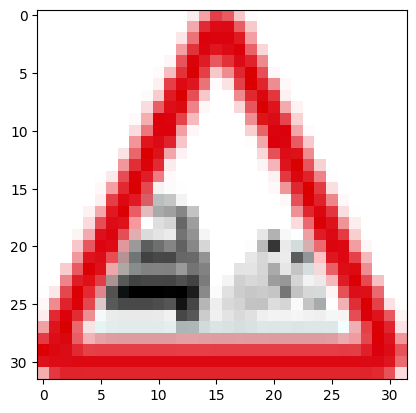

In [21]:
# Performing prediction on online random images
# img_path = "/content/abc.jpg"
# img_path = "/content/123.jpg"
# img_path = "/content/jhpolice_sl_mrs16.jpg"
# img_path = "/content/download.png"
# img_path = "/content/51OtjOKkO6L.jpg"
# img_path = "/content/789.webp"
# img_path = "/content/1.jpg"
img_path = "/content/new-img.png"


img = PIL.Image.open(img_path)
print(img.size)
plt.imshow(img)
plt.show()


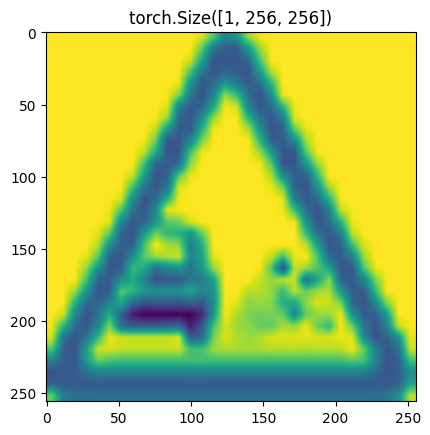

In [22]:
# Applying transforms to the PIL image
transformed_img = cur_transform(img)

plt.imshow(np.transpose(transformed_img, (1, 2, 0)))
plt.title(transformed_img.shape)
plt.show()

In [23]:
0# Adding batch dimentio to the image
final_image = transformed_img.unsqueeze(dim=0).to(device)
final_image.shape

torch.Size([1, 1, 256, 256])

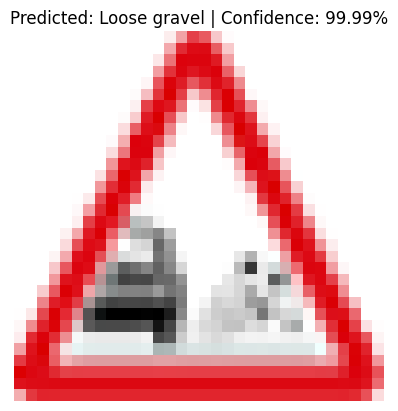

In [24]:
# Performing inference
with torch.inference_mode():
    y_logits = loaded_model(final_image)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0)
    predicted_class = y_pred.argmax().item()

# Model confidence
confidence = y_pred.max().item()

# convert image tensor to numpy array for image plotting
# pass

# Plotting the image
plt.imshow(img)  # converting pytorch CHW image to HWC
plt.title(f"Predicted: {classid_to_classname_map.get(predicted_class)} | Confidence: {confidence*100:.2f}%")
plt.axis('off')
plt.show()